In [1]:
import math
import os
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dataframe_image as dfi
from tqdm import tqdm
from DataTidy import json_reader, read_a_season, read_seasons, read_all_game

# Setup step:

Train set: from 2016-2017 to 2019-2020 (Including Regular games "02" and Playoffs "03")

Test set: 2020-2021 (Including Regular games "02" and Playoffs "03")

In [2]:
if not os.path.exists("csv"):
    os.makedirs("csv")
for year in [2016, 2017, 2018, 2019]: # 2020 has been excluded to be reserved as the test set
    read_a_season("nhl_data/",year).to_csv('csv/tidy_{season}.csv'.format(season = year), sep = ',', index = False)

100%|██████████████████████████████████████| 6433/6433 [00:57<00:00, 111.60it/s]


### Test Record

In [3]:
# For test:
#df_2019020001 = json_reader("nhl_data/2019020001.json")
df_2016020001 = json_reader("nhl_data/2016020001.json")
#df_2019020001.head(10)
df_2016020001.head(10)

,game_id,event_idx,play_type,shot_type,shot_dist,game_time,goals_home,goals_away,attack_team_name,period,period_time_rem,coordinate,shooter_name,goalie_name,empty_Net,strength,rink_side,angle_net,is_goal
0,2016020001,9,Shot,Wrist Shot,13.000000,2016-10-12T23:00:00Z,0,0,Toronto Maple Leafs,1,18:49,"{'x': -77.0, 'y': 5.0}",Mitchell Marner,Craig Anderson,None,None,right,-22.619865,0
1,2016020001,16,Shot,Wrist Shot,13.341664,2016-10-12T23:00:00Z,0,0,Ottawa Senators,1,17:07,"{'x': 86.0, 'y': 13.0}",Chris Kelly,Frederik Andersen,None,None,left,77.005383,0
2,2016020001,23,Shot,Wrist Shot,76.157731,2016-10-12T23:00:00Z,0,0,Ottawa Senators,1,15:59,"{'x': 23.0, 'y': -38.0}",Cody Ceci,Frederik Andersen,None,None,left,-29.931512,0
3,2016020001,25,Shot,Slap Shot,57.974132,2016-10-12T23:00:00Z,0,0,Ottawa Senators,1,15:14,"{'x': 33.0, 'y': -15.0}",Erik Karlsson,Frederik Andersen,None,None,left,-14.995079,0
4,2016020001,38,Shot,Wrist Shot,61.717096,2016-10-12T23:00:00Z,0,0,Toronto Maple Leafs,1,13:14,"{'x': -34.0, 'y': 28.0}",Martin Marincin,Craig Anderson,None,None,right,-26.980231,0
5,2016020001,40,Shot,Wrist Shot,58.523500,2016-10-12T23:00:00Z,0,0,Toronto Maple Leafs,1,12:30,"{'x': -33.0, 'y': -17.0}",Mitchell Marner,Craig Anderson,None,None,right,16.886791,0
6,2016020001,43,Goal,Wrist Shot,19.026298,2016-10-12T23:00:00Z,0,1,Toronto Maple Leafs,1,11:39,"{'x': -70.0, 'y': 1.0}",Auston Matthews,Craig Anderson,False,EVEN,right,-3.012788,1
7,2016020001,45,Shot,Wrist Shot,56.850682,2016-10-12T23:00:00Z,0,1,Toronto Maple Leafs,1,11:31,"{'x': -45.0, 'y': -36.0}",Matt Martin,Craig Anderson,None,None,right,39.289407,0
8,2016020001,48,Shot,Slap Shot,58.821765,2016-10-12T23:00:00Z,0,1,Ottawa Senators,1,11:00,"{'x': 33.0, 'y': -18.0}",Erik Karlsson,Frederik Andersen,None,None,left,-17.818889,0
9,2016020001,59,Shot,Wrist Shot,58.523500,2016-10-12T23:00:00Z,0,1,Ottawa Senators,1,09:44,"{'x': 34.0, 'y': 20.0}",Erik Karlsson,Frederik Andersen,None,None,left,19.983107,0


### Consolidating and Sorting CSV Files into a Unified DataFrame

In [4]:
directory = 'csv'

# Get a list of csv file names within the directory
csv_files = [f for f in os.listdir(directory) if f.endswith('.csv')]

# Sort the list of csv files
csv_files.sort()

# List to hold your DataFrames
dataframes_list = []

# Loop over the sorted list of csv files with tqdm for progress indication
for filename in tqdm(csv_files, desc="Loading files", unit="file"):
    file_path = os.path.join(directory, filename)
    df = pd.read_csv(file_path)

    # Filter the DataFrame to only include rows where 5th and 6th digits of 'game_id' are '02' (Regular Season)
    df = df[df['game_id'].astype(str).str[4:6] == '02']

    dataframes_list.append(df)

# Concatenate all the DataFrames in the list into a single DataFrame
train_df = pd.concat(dataframes_list, ignore_index=True)

# Sort the DataFrame first by 'game_id' and then by 'event_idx'
train_df = train_df.sort_values(by=['game_id', 'event_idx'])

# Reset the index of the sorted DataFrame
train_df = train_df.reset_index(drop=True)

Loading files: 100%|████████████████████████████| 4/4 [00:01<00:00,  3.53file/s]


In [5]:
# Display the resulting DataFrame
train_df.head(10)

,game_id,event_idx,play_type,shot_type,shot_dist,game_time,goals_home,goals_away,attack_team_name,period,period_time_rem,coordinate,shooter_name,goalie_name,empty_Net,strength,rink_side,angle_net,is_goal
0,2016020001,9,Shot,Wrist Shot,13.000000,2016-10-12T23:00:00Z,0,0,Toronto Maple Leafs,1,18:49,"{'x': -77.0, 'y': 5.0}",Mitchell Marner,Craig Anderson,NaN,NaN,right,-22.619865,0
1,2016020001,16,Shot,Wrist Shot,13.341664,2016-10-12T23:00:00Z,0,0,Ottawa Senators,1,17:07,"{'x': 86.0, 'y': 13.0}",Chris Kelly,Frederik Andersen,NaN,NaN,left,77.005383,0
2,2016020001,23,Shot,Wrist Shot,76.157731,2016-10-12T23:00:00Z,0,0,Ottawa Senators,1,15:59,"{'x': 23.0, 'y': -38.0}",Cody Ceci,Frederik Andersen,NaN,NaN,left,-29.931512,0
3,2016020001,25,Shot,Slap Shot,57.974132,2016-10-12T23:00:00Z,0,0,Ottawa Senators,1,15:14,"{'x': 33.0, 'y': -15.0}",Erik Karlsson,Frederik Andersen,NaN,NaN,left,-14.995079,0
4,2016020001,38,Shot,Wrist Shot,61.717096,2016-10-12T23:00:00Z,0,0,Toronto Maple Leafs,1,13:14,"{'x': -34.0, 'y': 28.0}",Martin Marincin,Craig Anderson,NaN,NaN,right,-26.980231,0
5,2016020001,40,Shot,Wrist Shot,58.523500,2016-10-12T23:00:00Z,0,0,Toronto Maple Leafs,1,12:30,"{'x': -33.0, 'y': -17.0}",Mitchell Marner,Craig Anderson,NaN,NaN,right,16.886791,0
6,2016020001,43,Goal,Wrist Shot,19.026298,2016-10-12T23:00:00Z,0,1,Toronto Maple Leafs,1,11:39,"{'x': -70.0, 'y': 1.0}",Auston Matthews,Craig Anderson,False,EVEN,right,-3.012788,1
7,2016020001,45,Shot,Wrist Shot,56.850682,2016-10-12T23:00:00Z,0,1,Toronto Maple Leafs,1,11:31,"{'x': -45.0, 'y': -36.0}",Matt Martin,Craig Anderson,NaN,NaN,right,39.289407,0
8,2016020001,48,Shot,Slap Shot,58.821765,2016-10-12T23:00:00Z,0,1,Ottawa Senators,1,11:00,"{'x': 33.0, 'y': -18.0}",Erik Karlsson,Frederik Andersen,NaN,NaN,left,-17.818889,0
9,2016020001,59,Shot,Wrist Shot,58.523500,2016-10-12T23:00:00Z,0,1,Ottawa Senators,1,09:44,"{'x': 34.0, 'y': 20.0}",Erik Karlsson,Frederik Andersen,NaN,NaN,left,19.983107,0


### Segmenting DataFrame into Goals and No-Goals

In [6]:
# DataFrame for No Goals:
df_no_goals = train_df[train_df['is_goal'] == 0]
# DataFrame for Goals:
df_goals = train_df[train_df['is_goal'] == 1]

In [7]:
# View of the DataFrame for No Goals:
df_no_goals.head(5)
#df_no_goals.tail(5)

,game_id,event_idx,play_type,shot_type,shot_dist,game_time,goals_home,goals_away,attack_team_name,period,period_time_rem,coordinate,shooter_name,goalie_name,empty_Net,strength,rink_side,angle_net,is_goal
0,2016020001,9,Shot,Wrist Shot,13.000000,2016-10-12T23:00:00Z,0,0,Toronto Maple Leafs,1,18:49,"{'x': -77.0, 'y': 5.0}",Mitchell Marner,Craig Anderson,NaN,NaN,right,-22.619865,0
1,2016020001,16,Shot,Wrist Shot,13.341664,2016-10-12T23:00:00Z,0,0,Ottawa Senators,1,17:07,"{'x': 86.0, 'y': 13.0}",Chris Kelly,Frederik Andersen,NaN,NaN,left,77.005383,0
2,2016020001,23,Shot,Wrist Shot,76.157731,2016-10-12T23:00:00Z,0,0,Ottawa Senators,1,15:59,"{'x': 23.0, 'y': -38.0}",Cody Ceci,Frederik Andersen,NaN,NaN,left,-29.931512,0
3,2016020001,25,Shot,Slap Shot,57.974132,2016-10-12T23:00:00Z,0,0,Ottawa Senators,1,15:14,"{'x': 33.0, 'y': -15.0}",Erik Karlsson,Frederik Andersen,NaN,NaN,left,-14.995079,0
4,2016020001,38,Shot,Wrist Shot,61.717096,2016-10-12T23:00:00Z,0,0,Toronto Maple Leafs,1,13:14,"{'x': -34.0, 'y': 28.0}",Martin Marincin,Craig Anderson,NaN,NaN,right,-26.980231,0


In [8]:
# View of the DataFrame for Goals:
df_goals.head(5)
#df_goals.tail(5)

,game_id,event_idx,play_type,shot_type,shot_dist,game_time,goals_home,goals_away,attack_team_name,period,period_time_rem,coordinate,shooter_name,goalie_name,empty_Net,strength,rink_side,angle_net,is_goal
6,2016020001,43,Goal,Wrist Shot,19.026298,2016-10-12T23:00:00Z,0,1,Toronto Maple Leafs,1,11:39,"{'x': -70.0, 'y': 1.0}",Auston Matthews,Craig Anderson,False,EVEN,right,-3.012788,1
11,2016020001,61,Goal,Backhand,7.615773,2016-10-12T23:00:00Z,1,1,Ottawa Senators,1,09:34,"{'x': 82.0, 'y': 3.0}",Bobby Ryan,Frederik Andersen,False,EVEN,left,23.198591,1
14,2016020001,71,Goal,Slap Shot,55.009090,2016-10-12T23:00:00Z,2,1,Ottawa Senators,1,07:11,"{'x': 34.0, 'y': -1.0}",Erik Karlsson,Frederik Andersen,False,EVEN,left,-1.041627,1
15,2016020001,80,Goal,Snap Shot,30.870698,2016-10-12T23:00:00Z,2,2,Toronto Maple Leafs,1,05:42,"{'x': -76.0, 'y': -28.0}",Auston Matthews,Craig Anderson,False,EVEN,right,65.095231,1
24,2016020001,132,Goal,Wrist Shot,19.104973,2016-10-12T23:00:00Z,2,3,Toronto Maple Leafs,2,18:35,"{'x': 76.0, 'y': -14.0}",Auston Matthews,Craig Anderson,False,EVEN,left,-47.121096,1


# Question 1:

Using your training dataset create a tidied dataset for each SHOT/GOAL event, with the following columns (you can name them however you want):

- `Distance from net`: (shot_dist)
- `Angle from net`: (angle_net)
- `Is goal` (0 or 1): (is_goal)
- `Empty Net` (0 or 1; you can assume NaNs are 0): (empty_Net)

You can approximate the net as a single point (i.e., you don’t need to account for the width of the net when computing the distance or angle). You should be able to create this easily using the functionality you implemented for tidying data in Milestone 1, as you will only need the (x, y) coordinates for each shot/goal event. Create and include the following figures in your blog post and briefly discuss your observations (a few sentences):

- A histogram of shot counts (goals and no-goals separated), binned by distance
- A histogram of shot counts (goals and no-goals separated), binned by angle
- A 2D histogram where one axis is the distance and the other is the angle. You do not need to separate goals and no-goals.
  - **Hint**: check out jointplots.

As always, make sure all of your axes are labeled correctly, and you make the appropriate choice of axis scale.



### Question 1.1 (Histograms of shot counts (goals and no-goals separated), binned by distance)

In [9]:
# Function to Create and Save Histogram
def create_histogram(data, file_name, x_title, title, edge_color, color):
    # Create figure and calculate bins
    fig, ax = plt.subplots(figsize = (10, 5))
    num_bins = math.ceil((data.max() - data.min()) / 10)
    # Ensure the range covers the max value
    bins = np.arange(0, data.max() + 20, 10)
    
    # Create histogram
    ax.hist(data, bins = num_bins, color = color, edgecolor = edge_color)
    ax.grid(axis = 'y')
    ax.set_title(title)
    ax.set_xlabel('Net Distance')
    ax.set_ylabel(x_title)
    ax.set_xticks(bins)
    
    fig.savefig(file_name)

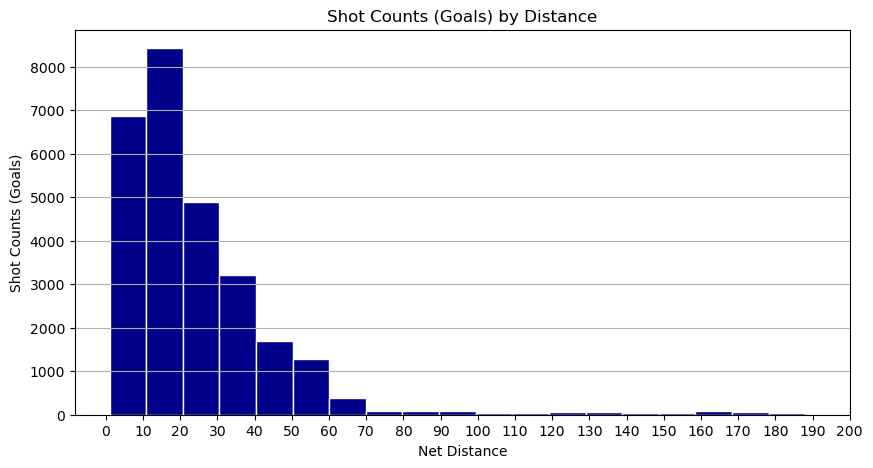

In [10]:
# Plot Histogram for Goals
create_histogram(
    df_goals['shot_dist'], 
    'FeatureEngineering1_Q2_1.png',
    'Shot Counts (Goals)',
    'Shot Counts (Goals) by Distance', 
    'white',
    '#00008B'
)

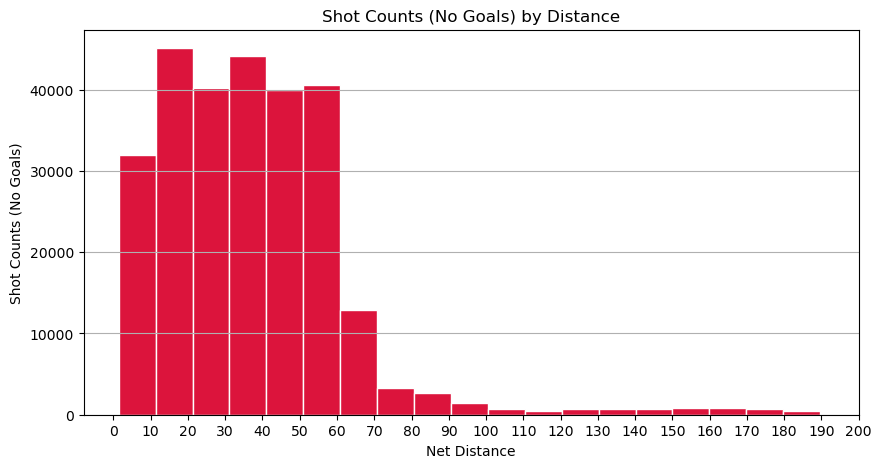

In [11]:
# Plot Histogram for No Goals
create_histogram(
    df_no_goals['shot_dist'],
    'FeatureEngineering1_Q2_2.png',
    'Shot Counts (No Goals)',
    'Shot Counts (No Goals) by Distance',
    'white',
    '#DC143C'
)

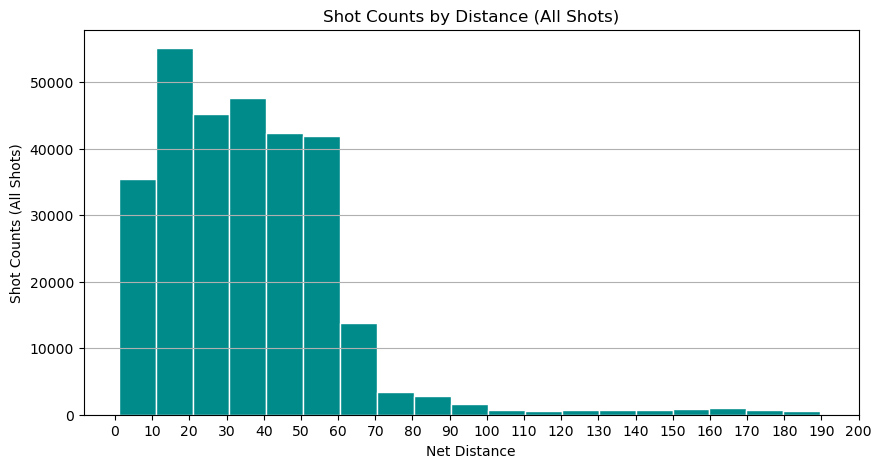

In [12]:
# Plot Histogram for Goals and No Goals
all_shots = pd.concat([df_goals['shot_dist'], df_no_goals['shot_dist']])

# Plot Histogram for All Shots (Goals and No Goals)
create_histogram(
    all_shots,
    'FeatureEngineering1_Q2_3.png',
    'Shot Counts (All Shots)',
    'Shot Counts by Distance (All Shots)',
    'white', 
    '#008B8B'
)

Two histograms from the 2016-17 to 2019-20 regular season games data show shot counts with and without goals, highlighting their distance from the net. The data reveals a sharp decrease in shots on goal beyond 70ft, with scoring chances diminishing at greater distances. Additionally, shots from a team's own half-rink at the opponent's goal are rare and seldom successful. This trend may be due to the reduced apparent size of the goal from a distance and increased reaction time for the goaltender.

### Question 1.2 (Histograms of shot counts (goals and no-goals separated), binned by angle)

In [13]:
# Function to plot histogram
def plot_histogram(data, filename, title, xlabel, ylabel, color, edge_color):
    # Calculate the number of bins
    bins = math.ceil((data.max() - data.min()) / 10)
    
    # Create figure and plot histogram
    fig, ax = plt.subplots(figsize = (10, 5))
    ax.hist(data, bins = bins, color = color, edgecolor = edge_color)
    ax.grid(axis = 'y')
    ax.set(title = title, xlabel = xlabel, ylabel = ylabel)
    ax.set_xticks(np.arange(-90, data.max() + 10, 10))
    
    fig.savefig(filename)

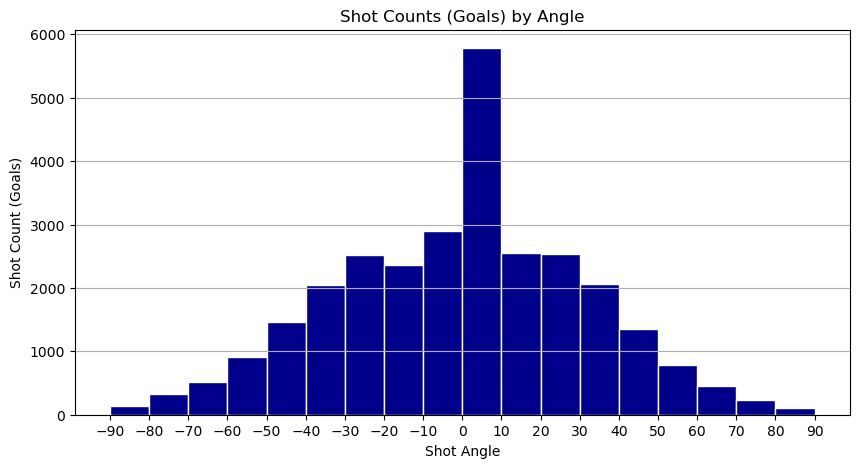

In [14]:
# Plot Histogram for Goals
plot_histogram(
    df_goals['angle_net'],
    'FeatureEngineering1_Q2_4.png',
    'Shot Counts (Goals) by Angle',
    'Shot Angle',
    'Shot Count (Goals)',
    '#00008B',
    'white'
)

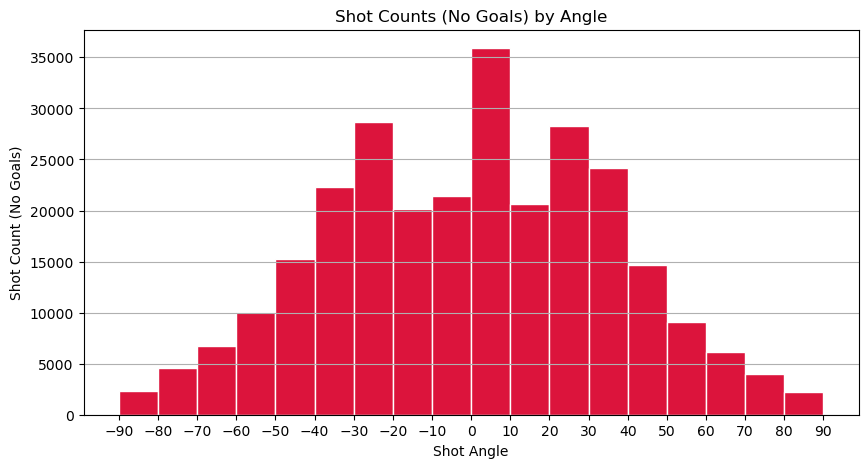

In [15]:
# Plot Histogram for No Goals
plot_histogram(
    df_no_goals['angle_net'],
    'FeatureEngineering1_Q2_5.png',
    'Shot Counts (No Goals) by Angle',
    'Shot Angle',
    'Shot Count (No Goals)',
    '#DC143C',
    'white'
)

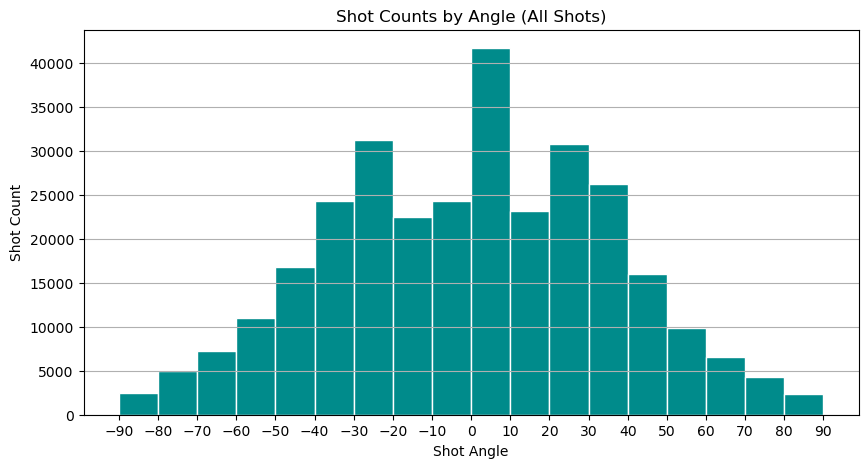

In [16]:
all_shots = pd.concat([df_goals['angle_net'], df_no_goals['angle_net']])

plot_histogram(
    all_shots,
    'FeatureEngineering1_Q2_6.png',
    'Shot Counts by Angle (All Shots)',
    'Shot Angle',
    'Shot Count',
    '#008B8B',
    'white'
)

Two histograms from the 2016-17 to 2019-20 regular season data show shot counts with and without goals, based on their angle to the net. The data indicates that shots are commonly taken either straight at the net or at around an abs(30-degree) angle. Goals are most frequently scored from direct shots. Beyond an abs(30) degrees, the likelihood of scoring decreases.

### Question 1.3 (2D histogram where one axis is the distance and the other is the angle)

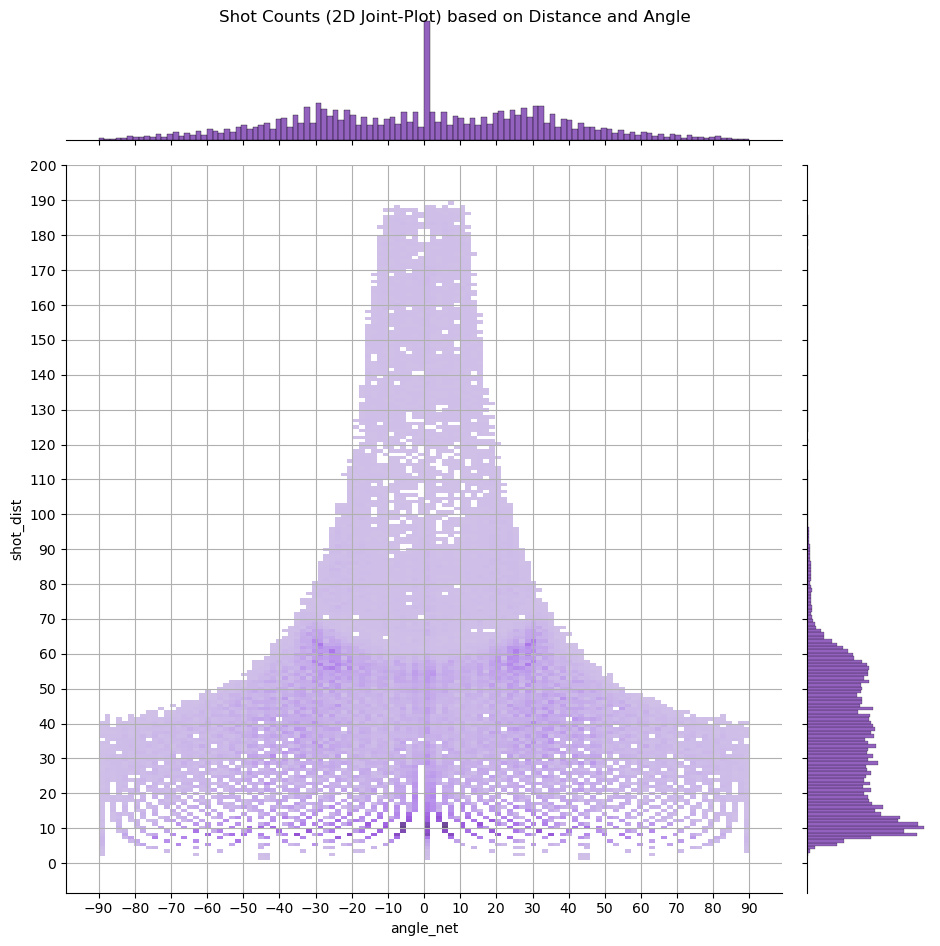

In [17]:
# Create the joint-plot with the specified parameters
joint_plot = sns.jointplot(
    data = train_df,
    kind = "hist",
    x = "angle_net",
    y = "shot_dist",
    color = '#6F2DA8'
)
joint_plot.fig.set_size_inches(10, 10)
joint_plot.ax_joint.grid(True)
joint_plot.fig.suptitle('Shot Counts (2D Joint-Plot) based on Distance and Angle')
joint_plot.ax_joint.set_xticks(np.arange(-90, 100, 10))
joint_plot.ax_joint.set_yticks(np.arange(0, 210, 10))

joint_plot.savefig("FeatureEngineering1_Q2_7.png")

The 2D histogram suggests a trend where shooters prefer wide-angle shots when near the goal and choose smaller angles from a distance. Key shooting zones are identified close to the goal, around 60 feet away, and at a 20 to 30-degree angle. The joint plot reveals a pattern of shots primarily taken from moderate distances with minimal angles. This decrease in shot frequency with greater distance or sharper angles is probably because shots become more challenging under these conditions.

# Question 2:

Now, create two more figures relating the goal rate, i.e., `#goals / (#no_goals + #goals)`, to the distance, and goal rate to the angle of the shot. Include these figures in your blog post and briefly discuss your observations.


/var/folders/6j/jvpvkjtd68g2vtfwt39f5k5c0000gn/T/ipykernel_52310/507221035.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_copy.assign(attempt=1).groupby('angle_shot_categories').agg({'attempt': 'sum', 'is_goal': 'sum'}).eval('success_rate = is_goal / attempt')


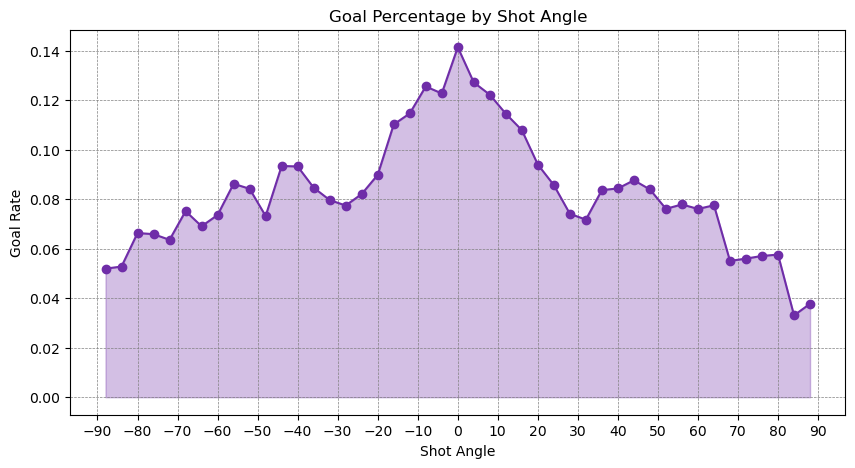

In [18]:
# Copying the dataframe and creating bins and bin centers
df_copy = train_df.copy()
bin_edges = np.arange(-90, 100, 4)
df_copy['angle_shot_categories'] = pd.cut(df_copy['angle_net'], bins=bin_edges, labels=(bin_edges[:-1] + bin_edges[1:]) / 2)
grouped = df_copy.assign(attempt=1).groupby('angle_shot_categories').agg({'attempt': 'sum', 'is_goal': 'sum'}).eval('success_rate = is_goal / attempt')

# Line plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(grouped.index, grouped['success_rate'], color='#6F2DA8', marker='o', linestyle='-')
ax.set(title='Goal Percentage by Shot Angle', xlabel='Shot Angle', ylabel='Goal Rate')
ax.set_xticks(np.arange(-90, 100, 10))
ax.grid(True, which='major', linestyle='--', linewidth='0.5', color='grey')
ax.fill_between(grouped.index, grouped['success_rate'], color='#6F2DA8', alpha=0.3)

# Save the plot
plt.savefig("FeatureEngineering1_Q2_8.png")

/var/folders/6j/jvpvkjtd68g2vtfwt39f5k5c0000gn/T/ipykernel_52310/2422356004.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_data = df_new.assign(shot_attempt=1).groupby('distance_bins').agg({'shot_attempt': 'sum', 'is_goal': 'sum'}).eval('success_rate = is_goal / shot_attempt')


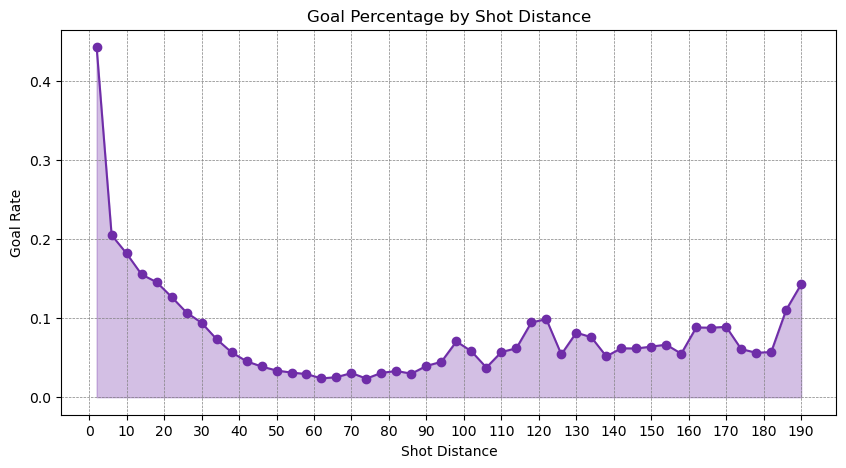

In [19]:
# Creating bins and categorizing 'shot_dist' in one line
df_new = train_df.copy()
df_new['distance_bins'] = pd.cut(train_df['shot_dist'], bins=np.arange(0, 204, 4), labels=np.arange(2, 202, 4))
summary_data = df_new.assign(shot_attempt=1).groupby('distance_bins').agg({'shot_attempt': 'sum', 'is_goal': 'sum'}).eval('success_rate = is_goal / shot_attempt')

# Line plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(summary_data.index, summary_data['success_rate'], color='#6F2DA8', marker='o', linestyle='-')
ax.set(title='Goal Percentage by Shot Distance', xlabel='Shot Distance', ylabel='Goal Rate')
ax.set_xticks(np.arange(0, 210, 10))
ax.grid(True, which='major', linestyle='--', linewidth='0.5', color='grey')
ax.fill_between(summary_data.index, summary_data['success_rate'], color='#6F2DA8', alpha=0.3)

# Save the plot
plt.savefig("FeatureEngineering1_Q2_9.png")

Two line charts show the goal rate based on the **angle** and **distance** to the net. They reveal that goals are more likely with closer proximity and smaller angles to the net. Interestingly, there's an increase in goal rate at longer distances, likely because players shoot from afar more often when the net is empty, enhancing the scoring chances.

# Question 3:

Finally, let's do some quick checks to see if our data makes sense. Unfortunately, we don't have time to do automated anomaly detection, but we can use our "domain knowledge" for some quick sanity checks! The domain knowledge is that "it is incredibly rare to score a non-empty net goal on the opposing team from within your defensive zone." Knowing this, create another histogram, this time of goals only, binned by distance, and separate empty net and non-empty net events. Include this figure in your blog post and discuss your observations. Can you find any events that have incorrect features (e.g., wrong x/y coordinates)? If yes, prove that one event has incorrect features.

- **Hint**: the NHL gamecenter usually has video clips of goals for every game.

In [20]:
# Goal Success Analysis in Hockey: With vs. Without Goalies
empty_net_goals = train_df.query('empty_Net == 1 and is_goal == 1')
goalie_net_goals = train_df.query('empty_Net == 0 and is_goal == 1')

# Histogram Bin Calculation
bin_step = 10
bins_empty = np.arange(empty_net_goals['shot_dist'].min(), empty_net_goals['shot_dist'].max() + bin_step, bin_step)
bins_goalie = np.arange(goalie_net_goals['shot_dist'].min(), goalie_net_goals['shot_dist'].max() + bin_step, bin_step)

# Histogram Plotting Function
def plot_goals_hist(data, title, x_label, y_label, bins, color, save_path):
    plt.figure(figsize=(10, 5))
    plt.hist(data, bins=bins, edgecolor='white', color=color)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xticks(np.arange(0, 210, 10))
    plt.grid(axis='y')
    plt.savefig(save_path)

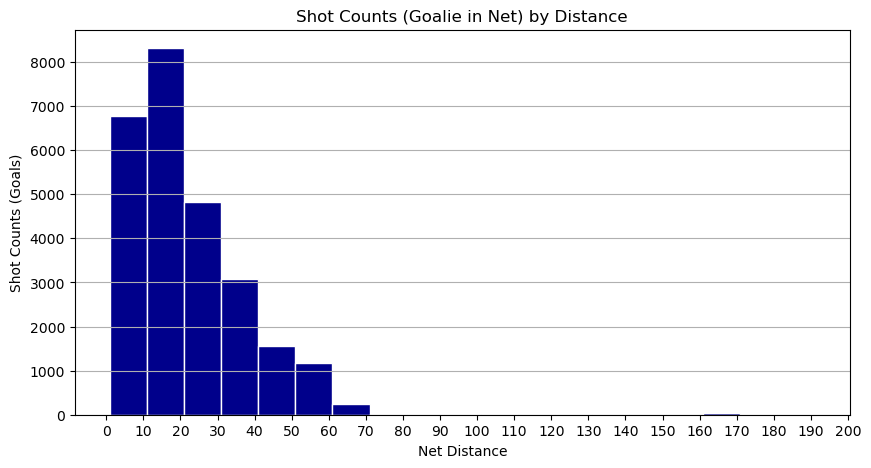

In [21]:
# Plot Histogram for Goals with Goalie in Net
plot_goals_hist(
    goalie_net_goals['shot_dist'],
    'Shot Counts (Goalie in Net) by Distance',
    'Net Distance',
    'Shot Counts (Goals)',
    bins_goalie,
    '#00008B',
    'FeatureEngineering1_Q2_10.png'
)

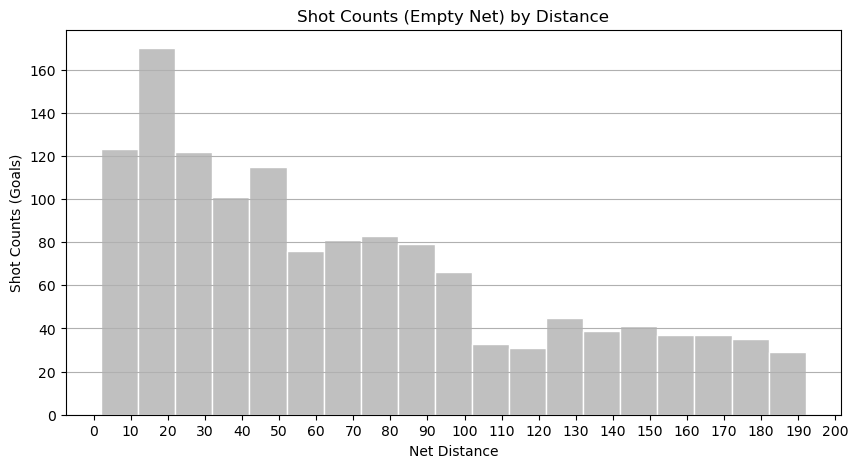

In [22]:
# Plot Histogram for Goals with Empty Net
plot_goals_hist(
    empty_net_goals['shot_dist'],
    'Shot Counts (Empty Net) by Distance',
    'Net Distance',
    'Shot Counts (Goals)',
    bins_empty,
    'silver',
    'FeatureEngineering1_Q2_11.png'
)

#### The prove that some events have incorrect features:

In [23]:
# Filtering the DataFrame for goals with unusual conditions
def is_anomalous_goal(row):
    x_coord = abs(ast.literal_eval(row['coordinate']).get('x', 0))
    is_far_shot = row['shot_dist'] > 89
    is_net_full = row['empty_Net'] == 0

    return x_coord > 89 and is_far_shot and is_net_full

# Apply the filter function to the DataFrame
anomalous_goals = df_goals[df_goals.apply(is_anomalous_goal, axis=1)]

# Save the resulting DataFrame as a PNG file
dfi.export(anomalous_goals, 'FeatureEngineering1_Q2_12.png')
anomalous_goals

,game_id,event_idx,play_type,shot_type,shot_dist,game_time,goals_home,goals_away,attack_team_name,period,period_time_rem,coordinate,shooter_name,goalie_name,empty_Net,strength,rink_side,angle_net,is_goal
30946,2016020510,167,Goal,Slap Shot,187.18173,2016-12-24T00:30:00Z,3,1,Florida Panthers,2,09:33,"{'x': -97.0, 'y': 21.0}",Derek MacKenzie,Jared Coreau,False,EVEN,left,6.4416,1


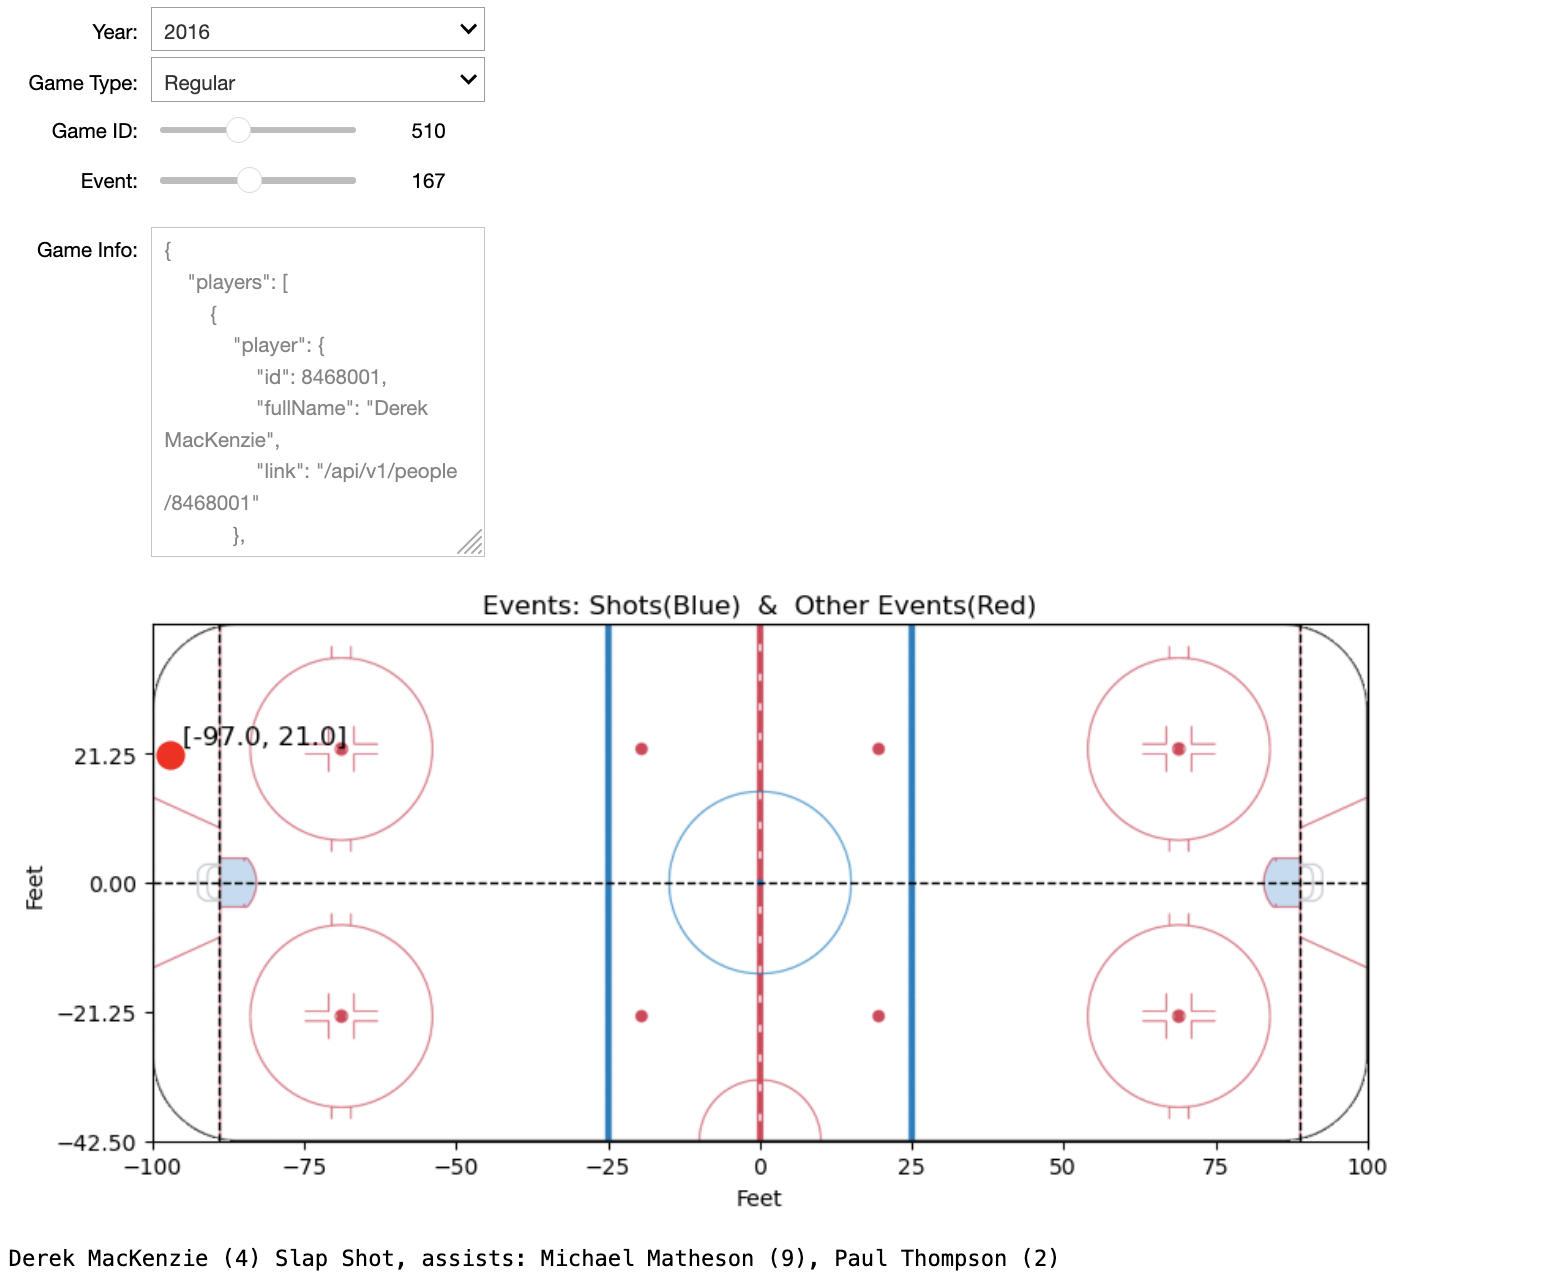

This filtering aims to identify anomalous goal events in a hockey dataset where goals from a distance greater than 89 units (from opposing team) and not into an empty net are considered anomalies.